### **Load libraries**

In [1]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('selected_stocks_rets.csv', index_col=0)
stocks = pd.read_csv('selected_stocks_stocks.csv', index_col=0)

In [5]:
expected_returns = pd.read_csv('expected_returns.csv', index_col=0, header=None).iloc[:,0]
expected_covmat = pd.read_csv('expected_covmat.csv', index_col=0)

In [6]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

# **Initial examination**

In [7]:
summary_stats = rk.summary_stats(rets, periods_per_year=periods_per_year, riskfree_rate=0)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
CNEC.CL,-0.151660,0.397962,2.794582,32.571353,0.007466,0.105538,-0.381092,-0.923684
AAPL,0.288871,0.281328,-0.195536,5.083081,0.058017,0.082014,1.026811,-0.346408
AMZN,0.219934,0.305140,-0.099529,4.439446,0.063710,0.089718,0.720766,-0.548307
BAC,0.154322,0.319981,0.000959,6.155126,0.065228,0.095854,0.482285,-0.464260
BAP,0.142683,0.317511,0.177493,8.157371,0.060963,0.090910,0.449379,-0.577136
BRK-B,0.149299,0.194502,-0.198236,5.540954,0.040720,0.057133,0.767599,-0.264770
BVN,0.214265,0.460221,0.084560,9.144205,0.088150,0.126078,0.465570,-0.689323
C,0.114324,0.344067,-0.046510,7.984146,0.069812,0.105081,0.332273,-0.534781
CBU7.L,0.016984,0.040521,0.216750,6.046442,0.008059,0.012274,0.419155,-0.140871
CFMITNIPSA.SN,0.077273,0.194861,-0.402031,10.596702,0.040767,0.059339,0.396557,-0.472281


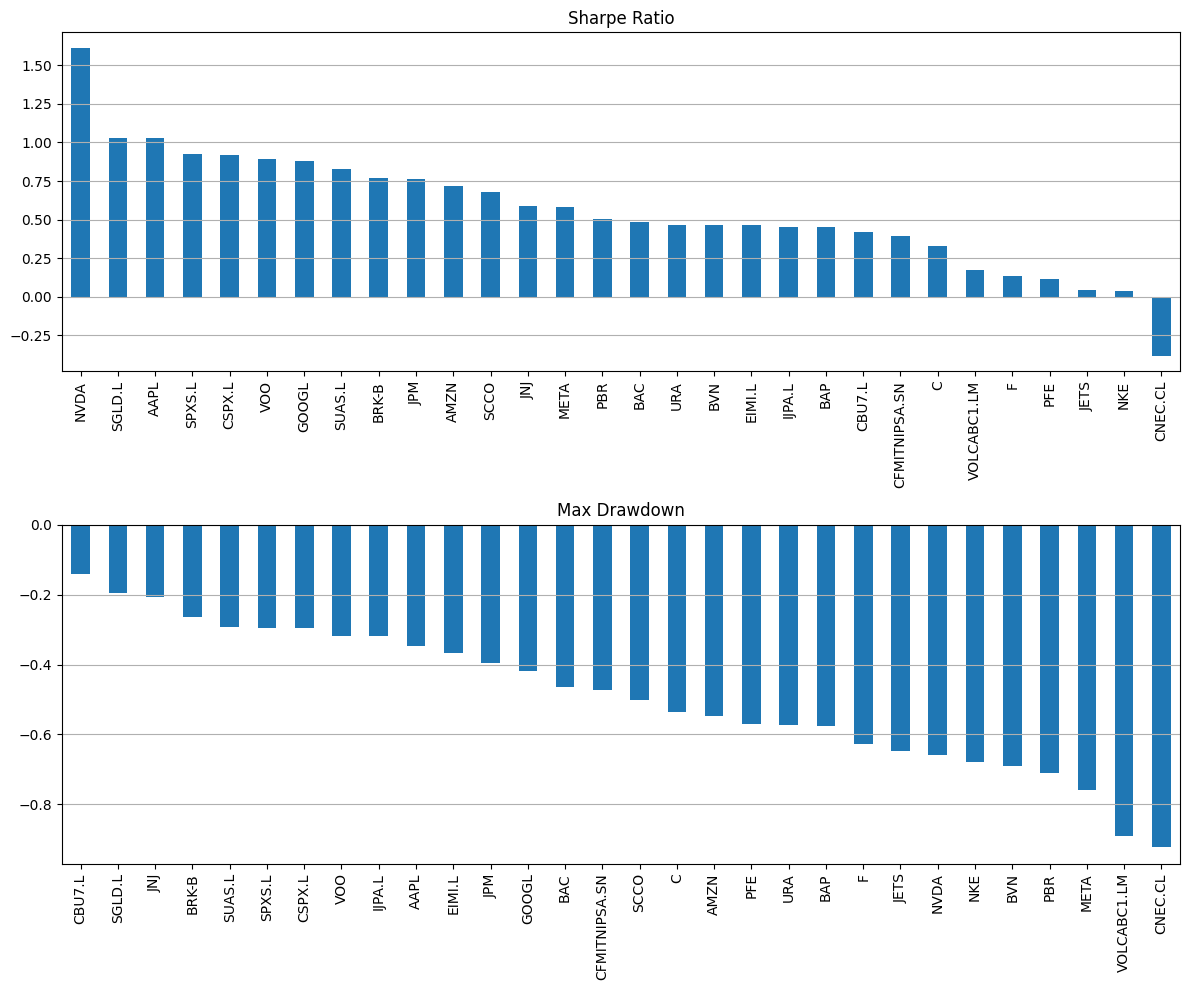

In [8]:
# Plot some return, volatility, and risk rankings to get a view of relevant stocks
summary_stats = rk.summary_stats(rets, periods_per_year=periods_per_year)
#plot1_series = summary_stats['Annualized Return'].sort_values(ascending=False)
#plot2_series = summary_stats['Annualized Volatility'].sort_values(ascending=True)
#plot1_series = summary_stats['Cornish-Fisher VaR (5%)'].sort_values(ascending=False)
#plot2_series = summary_stats['Historic CVaR (5%)'].sort_values(ascending=False)
plot1_series = summary_stats['Sharpe Ratio'].sort_values(ascending=False)
plot2_series = summary_stats['Max Drawdown'].sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot1_series.plot.bar(ax = axes[0], legend=False, title=plot1_series.name)
plot2_series.plot.bar(ax=axes[1], legend=False, title=plot2_series.name)
axes[0].grid(axis='y')
axes[1].grid(axis='y')
plt.tight_layout()

In [9]:
# Identify stock pairs with very high correlation

# Generate correlation matrix
corr_mat = rets.corr()
# Generate a mask to exclude  duplicated pairs
#mask = np.triu(np.ones_like(corr_mat))
#corr_mat = corr_mat*mask
# Convert the matrix into a dataframe structured as a list of pairs with their respective correlations
stack_corr = pd.DataFrame(corr_mat.stack())
stack_corr = stack_corr[stack_corr[0] < 1]
stack_corr = stack_corr[stack_corr[0] != 0]
stack_corr.index.names = ['Stock 1', 'Stock 2']
stack_corr.reset_index(inplace=True)
#(abs(stack_corr[0]) > .7).sum()

# Filter to visualize only the pairs with very high correlations
high_corrs = stack_corr[stack_corr[0] >= 0.8].sort_values(by=0, ascending=False)
high_corrs

,Stock 1,Stock 2,0
735,SPXS.L,CSPX.L,0.999063
314,CSPX.L,SPXS.L,0.999063
779,SUAS.L,SPXS.L,0.953117
750,SPXS.L,SUAS.L,0.953117
315,CSPX.L,SUAS.L,0.952749
764,SUAS.L,CSPX.L,0.952749
851,VOO,CSPX.L,0.923976
318,CSPX.L,VOO,0.923976
866,VOO,SPXS.L,0.922456
753,SPXS.L,VOO,0.922456


In [10]:
# Check the average correlation coefficient of each stock
stack_corr.groupby('Stock 1')[0].mean().sort_values(ascending=False)

Stock 1
VOO              0.542296
CSPX.L           0.532217
SPXS.L           0.531695
SUAS.L           0.501024
EIMI.L           0.454070
C                0.443625
IJPA.L           0.426602
JPM              0.423575
JETS             0.418810
BAC              0.414761
BRK-B            0.406708
SCCO             0.374509
F                0.366533
GOOGL            0.339046
NKE              0.337275
AAPL             0.336010
URA              0.323582
NVDA             0.319906
AMZN             0.317783
BAP              0.303887
CFMITNIPSA.SN    0.295046
META             0.290785
JNJ              0.246607
PBR              0.240283
PFE              0.230330
VOLCABC1.LM      0.198467
BVN              0.166211
CNEC.CL          0.126957
SGLD.L           0.117304
CBU7.L          -0.000888
Name: 0, dtype: float64

# **Identify Combination with the maximum Sharpe-Ratio**

In [11]:
# Based on historical returns
n_periods = 162
# returns = rk.summary_stats(rets.iloc[-n_periods:], periods_per_year=periods_per_year)['Annualized Return']
# covmat = rets.iloc[-n_periods:].cov()

# Based on predicted returns
returns = expected_returns
covmat = expected_covmat

In [12]:
# Loop that calculates the combination that maximizes the Sharpe ratio several times until no stock has less than 5% of weight
rf_rate = .11   # Currently, the 10-Y  bond yield is at 11.2%
max_weight = 0.15 # The maximum weight allowed for a stock
min_weight = .05 # The minimum weight allowed for a stock
initial_weights = rk.msr_tuned(riskfree_rate=rf_rate,
                         returns=returns,
                         covmat=covmat,
                         max_weight=max_weight,
                         periods_per_year=periods_per_year)
optimal_allocation = pd.DataFrame(data=initial_weights, index=returns.index, columns=['Weights']).sort_values(by='Weights')

while optimal_allocation.min().values < min_weight:
    optimal_allocation = optimal_allocation[1:]
    weights = rk.msr_tuned(riskfree_rate=rf_rate,
                     returns=returns[optimal_allocation.index],
                     covmat=covmat.loc[optimal_allocation.index, optimal_allocation.index],
                     max_weight=max_weight,
                     periods_per_year=periods_per_year)
    optimal_allocation = pd.DataFrame(data=weights, index=optimal_allocation.index, columns=['Weights']).sort_values(by='Weights')

chosen_allocation = optimal_allocation
chosen_allocation

,Weights
0,
PBR,0.084800
PFE,0.123073
SGLD.L,0.192126
SUAS.L,0.300000
CBU7.L,0.300000


In [13]:
"""
# Alternative methodology finding the combination that maximizes the Sharpe ratio and then removing any stock with a weight below 5%
rf_rate = .11   # Currently, the 10-Y  bond yield is at 11.2%

weights = rk.msr(riskfree_rate=rf_rate, return_series=rets, periods_per_year=periods_per_year)
optimal_allocation = pd.DataFrame(data=weights.round(4), index=rets.columns, columns=['Weights'])
optimal_allocation = optimal_allocation[optimal_allocation['Weights'] >= .05]

# Reduce the portfolio stocks to only those for which shares of over 3% is recommended
chosen_allocation = optimal_allocation[optimal_allocation['Weights'] > .05]
chosen_allocation = chosen_allocation / chosen_allocation.sum()
chosen_allocation.sort_values(by='Weights')
"""

"\n# Alternative methodology finding the combination that maximizes the Sharpe ratio and then removing any stock with a weight below 5%\nrf_rate = .11   # Currently, the 10-Y  bond yield is at 11.2%\n\nweights = rk.msr(riskfree_rate=rf_rate, return_series=rets, periods_per_year=periods_per_year)\noptimal_allocation = pd.DataFrame(data=weights.round(4), index=rets.columns, columns=['Weights'])\noptimal_allocation = optimal_allocation[optimal_allocation['Weights'] >= .05]\n\n# Reduce the portfolio stocks to only those for which shares of over 3% is recommended\nchosen_allocation = optimal_allocation[optimal_allocation['Weights'] > .05]\nchosen_allocation = chosen_allocation / chosen_allocation.sum()\nchosen_allocation.sort_values(by='Weights')\n"

<Axes: xlabel='Date'>

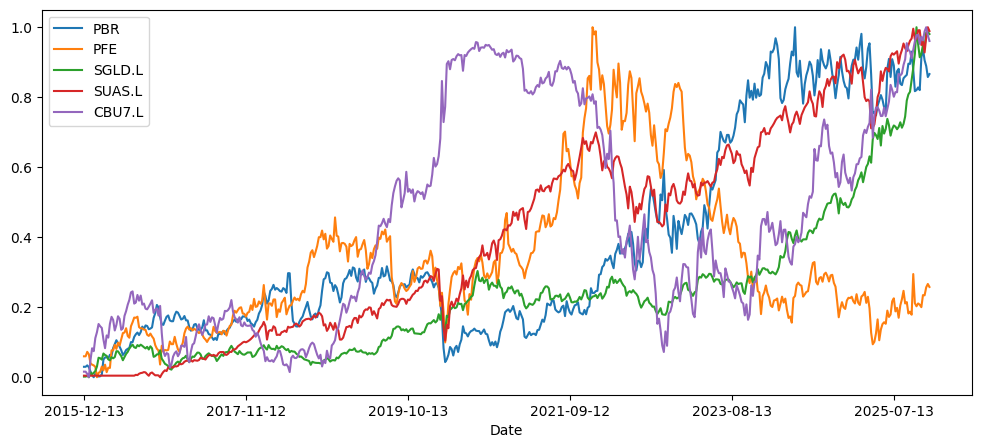

In [14]:
normalized_stocks = (stocks - stocks.min()) / (stocks.max() - stocks.min())
normalized_stocks[optimal_allocation.index].plot(figsize=(12, 5))

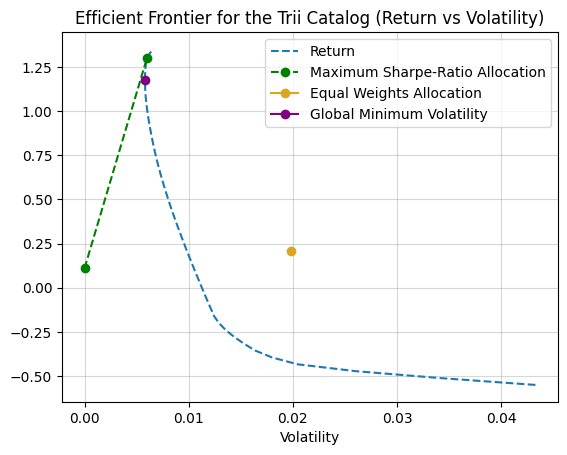

In [15]:
rk.plot_ef(50, style='--', show_cml=True, show_ew=True, show_gmv=True, riskfree_rate=rf_rate,
           returns=returns, covmat=covmat, periods_per_year=periods_per_year)
plt.title('Efficient Frontier for the Trii Catalog (Return vs Volatility)')
plt.grid(alpha=.5)

# **Create an index for the chosen allocation**

In [16]:
# Generate a dataframe to represent the evolution of the allocation in each stock
weights = chosen_allocation['Weights']
allocated_index = (rets[weights.index] + 1).cumprod()*weights

# Add a column to represent the index
allocated_index['index'] = allocated_index.sum(axis='columns')
allocated_index.index = pd.to_datetime(allocated_index.index.str.split('/').str[0])

# Generate a row to represent an earlier period before returns are made,
# corresponding to the time when the index equal 1
first_period = allocated_index.index[0]
starting_period = first_period - pd.offsets.Week(weekday=6)   # Uncomment to generate a week starting period
#starting_period = first_period - pd.offsets.DateOffset(months=1)   # Uncomment to generate a month starting period
starting_period

allocation_start = pd.DataFrame(index=[starting_period], columns=allocated_index.columns)
allocation_start.iloc[:, :-1] = 1*weights
allocation_start['index'] = 1

# Append the row to the allocated_index dataframe
allocated_index = pd.concat([allocation_start, allocated_index], axis='rows')
allocated_index.head()

,PBR,PFE,SGLD.L,SUAS.L,CBU7.L,index
2015-12-13,0.0848,0.123073,0.192126,0.3,0.3,1.000000
2015-12-20,0.0848,0.123073,0.192126,0.3,0.3,1.000000
2015-12-27,0.08831,0.125497,0.193366,0.3,0.299641,1.006813
2016-01-03,0.083826,0.124189,0.191134,0.3,0.299108,0.998257
2016-01-10,0.073104,0.119265,0.199013,0.3,0.301846,0.993228


In [17]:
# Generate a dataframe with the returns of the index
allocated_index_returns = (allocated_index/allocated_index.shift(1) - 1).dropna()
allocated_index_returns.tail()

,PBR,PFE,SGLD.L,SUAS.L,CBU7.L,index
2025-11-16,0.024883,0.043851,0.020198,0.008683,-0.001611,0.016325
2025-11-23,-0.031866,-0.000798,-0.005298,-0.02439,0.00407,-0.017654
2025-11-30,-0.017241,0.027955,0.032926,0.032941,0.001887,0.015379
2025-12-07,-0.032695,0.011267,0.001036,0.021071,-0.003627,-0.001253
2025-12-14,0.009068,-0.009988,-0.004436,-0.007808,-0.00259,-0.002197


In [18]:
summary_stats = rk.summary_stats(allocated_index_returns, periods_per_year=periods_per_year, riskfree_rate=0)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
PBR,0.262380,0.521944,0.721840,11.663530,0.082337,0.140307,0.502697,-0.710030
PFE,0.028068,0.242325,0.153957,4.900353,0.050463,0.070859,0.115828,-0.571144
SGLD.L,0.149996,0.145504,0.113471,5.008106,0.028336,0.039937,1.030874,-0.194443
SUAS.L,0.138203,0.167425,-0.549797,10.008602,0.035023,0.051167,0.825466,-0.293075
CBU7.L,0.016984,0.040521,0.216750,6.046442,0.008059,0.012274,0.419155,-0.140871
index,0.124567,0.132802,-0.854277,9.409311,0.029188,0.041206,0.937985,-0.246385


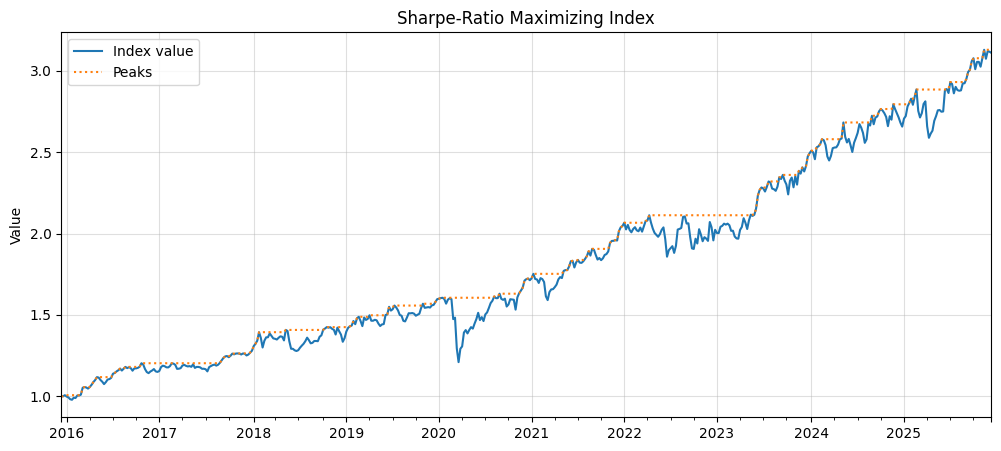

In [19]:
# Visualize the evolution of the index
allocated_index['index'].plot(figsize=(12, 5), label='Index value')
allocated_index['index'].cummax().plot(linestyle=':', label='Peaks')
plt.legend()
plt.ylabel('Value')
plt.title('Sharpe-Ratio Maximizing Index')
plt.grid(alpha=0.4)

### **Export datasets and an index for the Sharpe-Ratio maximizing allocation**

In [20]:
# Allocation index and returns
allocated_index.to_csv('allocated_index.csv')
allocated_index_returns.to_csv('allocated_index_returns.csv')